In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.6 MB/s eta 0:00:00


In [ ]:
import kagglehub
import shutil
import os
import xml.etree.ElementTree as ET
import random
from ultralytics import YOLO
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
path = kagglehub.dataset_download(handle="andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-detection' dataset.
Path to dataset files: /kaggle/input/face-mask-detection


In [ ]:
src = path
dst = "/content/face-mask-detection"

shutil.copytree(src, dst, dirs_exist_ok=True)

print("Copied to:", dst)

Copied to: /content/face-mask-detection


In [ ]:
xml_folder = f"{dst}/annotations"
labels_out = f"{dst}/labels"

os.makedirs(labels_out, exist_ok=True)

classes = ["with_mask", "mask_weared_incorrect", "without_mask"]

def voc_to_yolo(size, box):
    w, h = size
    xmin, ymin, xmax, ymax = box

    x_center = ((xmin + xmax) / 2) / w
    y_center = ((ymin + ymax) / 2) / h
    width = (xmax - xmin) / w
    height = (ymax - ymin) / h

    return x_center, y_center, width, height

for file in os.listdir(xml_folder):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_folder, file)
    root = ET.parse(xml_path).getroot()

    img_w = int(root.find("size/width").text)
    img_h = int(root.find("size/height").text)

    yolo_label_path = os.path.join(labels_out, file.replace(".xml", ".txt"))
    with open(yolo_label_path, "w") as out:

        for obj in root.findall("object"):
            cls = obj.find("name").text
            cls_id = classes.index(cls)

            b = obj.find("bndbox")
            xmin = int(b.find("xmin").text)
            ymin = int(b.find("ymin").text)
            xmax = int(b.find("xmax").text)
            ymax = int(b.find("ymax").text)

            bb = voc_to_yolo((img_w, img_h), (xmin, ymin, xmax, ymax))
            out.write(f"{cls_id} " + " ".join(str(v) for v in bb) + "\n")

print("XML → YOLO conversion complete.")

XML → YOLO conversion complete.


**Splitting the data**

In [ ]:
images_dir = f"{dst}/images"       # folder containing all images
labels_dir = f"{dst}/labels"       # folder containing all YOLO txt files

output_base = "/content/face-mask-data/"

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1


for split in ["train", "val", "test"]:
    os.makedirs(f"{output_base}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_base}/labels/{split}", exist_ok=True)


image_files = [f for f in os.listdir(images_dir)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

random.shuffle(image_files)
total = len(image_files)

train_end = int(total * train_ratio)
val_end   = train_end + int(total * val_ratio)

splits = {
    "train": image_files[:train_end],
    "val":   image_files[train_end:val_end],
    "test":  image_files[val_end:]
}

for split, imgs in splits.items():
    print(f"Moving {len(imgs)} images to {split}...")

    for img_name in imgs:
        img_src = os.path.join(images_dir, img_name)
        img_dst = os.path.join(output_base, "images", split, img_name)

        shutil.copy(img_src, img_dst)

        label_name = img_name.rsplit(".", 1)[0] + ".txt"
        label_src = os.path.join(labels_dir, label_name)
        label_dst = os.path.join(output_base, "labels", split, label_name)

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)

print("✅ Dataset split completed!")


Moving 597 images to train...
Moving 170 images to val...
Moving 86 images to test...
✅ Dataset split completed!


In [ ]:
yaml_content = f"""
path: /content/face-mask-data
train: /content/face-mask-data/images/train
val: /content/face-mask-data/images/val
test: /content/face-mask-data/images/test
names: {classes}
"""

with open("/content/face-mask-data/dataset.yaml", "w") as f:
    f.write(yaml_content)

print("🟢 dataset.yaml created!")

🟢 dataset.yaml created!


In [ ]:
old_data_path = '/content/face-mask-detection'
if os.path.exists(old_data_path):
    shutil.rmtree(old_data_path)
    print(f"Successfully deleted: {old_data_path}")
else:
    print(f"Directory not found: {old_data_path}")

Successfully deleted: /content/face-mask-detection


In [ ]:
model = YOLO('yolov8m.pt')

**Model training**

In [ ]:
model.train(
    data= '/content/face-mask-data/dataset.yaml',
    epochs= 100,
    augment= True,
    imgsz= 640,
    batch= 16,
    device= 0,
    cache= True,
    patience= 15,
    optimizer= 'AdamW',
    lr0=0.001,
    weight_decay=0.0005
)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/face-mask-data/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=15, perspective=0.0, plots=True, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789444262480>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
test_model = YOLO('/content/runs/detect/train2/weights/best.pt')


image 1/1 /content/face-mask-data/images/test/maksssksksss173.png: 480x640 2 with_masks, 1 mask_weared_incorrect, 28.5ms
Speed: 2.1ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


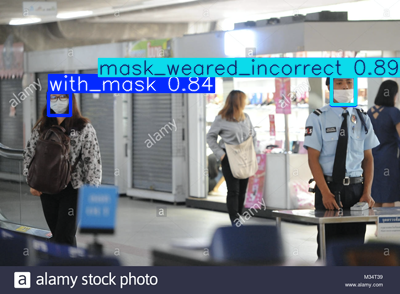

In [ ]:
# Run inference
results = test_model("/content/face-mask-data/images/test/maksssksksss173.png")  # single image
results[0].show()